<div style='background-color:#E74C3C; padding: 15px; border-radius: 10px; margin-bottom: 20px;'>
<h1 style='color:#FFFFFF; text-align:center; font-family: Arial, sans-serif; margin: 0;'>🤖 Machine Learning Model Development</h1>
<h2 style='color:#FADBD8; text-align:center; font-family: Arial, sans-serif; margin: 5px 0 0 0;'>Predictive Analytics for Stroke Risk</h2>
</div>

<div style='background-color:#FDEDEC; padding: 15px; border-radius: 8px; border-left: 4px solid #E74C3C;'>
<h3 style='color:#E74C3C; margin-top: 0;'>🎯 Modeling Objectives</h3>
<ul style='color:#333; line-height: 1.6;'>
<li><strong>Algorithm Selection:</strong> Evaluate multiple ML algorithms for stroke prediction</li>
<li><strong>Model Training:</strong> Train and optimize predictive models</li>
<li><strong>Hyperparameter Tuning:</strong> Fine-tune model parameters for optimal performance</li>
<li><strong>Cross-Validation:</strong> Ensure model robustness and prevent overfitting</li>
<li><strong>Clinical Validation:</strong> Validate models for healthcare application</li>
</ul>
</div>

# **04 - Machine Learning Model Development**

## Objectives

* Train and compare multiple machine learning models for stroke prediction
* Implement proper model selection and hyperparameter tuning
* Handle class imbalance in the stroke dataset
* Evaluate models using appropriate metrics for healthcare applications
* Select the best performing model for deployment

## Inputs

* outputs/datasets/TrainSet.csv
* outputs/datasets/TestSet.csv
* outputs/ml_pipeline/feature_engineering_pipeline.pkl

## Outputs

* Trained machine learning models saved as .pkl files
* Model performance comparison plots
* Feature importance analysis
* Best model selection and justification

---

# Change working directory

In [27]:
import os
# Change to parent directory to access outputs folder
current_dir = os.getcwd()
if current_dir.endswith('jupyter_notebooks'):
    os.chdir(os.path.dirname(current_dir))
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\midas\Documents\2505-WMCA-Data-Git101\Stroke-prediction\stroke-prediction


---

# Load Required Libraries and Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from sklearn.model_selection import (
    cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    classification_report, confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from scipy import stats

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

## Load Preprocessed Data

In [4]:
# Load processed data from feature engineering notebook
import numpy as np
import pickle

try:
    # Load the processed data
    data = np.load('jupyter_notebooks/outputs/datasets/processed_stroke_data.npz')
    X_train = data['X_train']
    X_val = data['X_val'] 
    X_test = data['X_test']
    y_train = data['y_train']
    y_val = data['y_val']
    y_test = data['y_test']
    
    # Load preprocessing pipeline
    with open('jupyter_notebooks/outputs/datasets/preprocessing_pipeline.pkl', 'rb') as f:
        pipeline_data = pickle.load(f)
        preprocessor = pipeline_data['preprocessor']
        numerical_features = pipeline_data['numerical_features']
        categorical_features = pipeline_data['categorical_features']
    
    print("✅ Processed data loaded successfully!")
    print(f"Training set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")
    print(f"Test set: {X_test.shape}")
    print(f"Stroke rate - Train: {y_train.mean():.3f}, Val: {y_val.mean():.3f}, Test: {y_test.mean():.3f}")

except FileNotFoundError:
    print("❌ Processed data not found. Loading and processing raw data...")
    
    # Load raw data and do basic preprocessing
    df = pd.read_csv("jupyter_notebooks/inputs/datasets/Stroke-data.csv")
    
    # Basic preprocessing
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from sklearn.impute import SimpleImputer
    
    # Handle missing values
    df['bmi'].fillna(df['bmi'].median(), inplace=True)
    
    # Prepare features and target
    X = df.drop(['stroke', 'id'], axis=1)
    y = df['stroke']
    
    # Encode categorical variables
    label_encoders = {}
    categorical_cols = X.select_dtypes(include=['object']).columns
    
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le
    
    # Split data
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)
    
    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    print("✅ Basic preprocessing completed!")
    print(f"Training set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")
    print(f"Test set: {X_test.shape}")
    print(f"Stroke rate - Train: {y_train.mean():.3f}, Val: {y_val.mean():.3f}, Test: {y_test.mean():.3f}")

✅ Processed data loaded successfully!
Training set: (3066, 27)
Validation set: (1022, 27)
Test set: (1022, 27)
Stroke rate - Train: 0.049, Val: 0.049, Test: 0.049


---
# Model Development Strategy

## Class Imbalance Analysis

Class Distribution Analysis:
Class 0 (No Stroke): 2,917 samples
Class 1 (Stroke): 149 samples
Imbalance ratio: 19.6:1
Positive class percentage: 4.9%


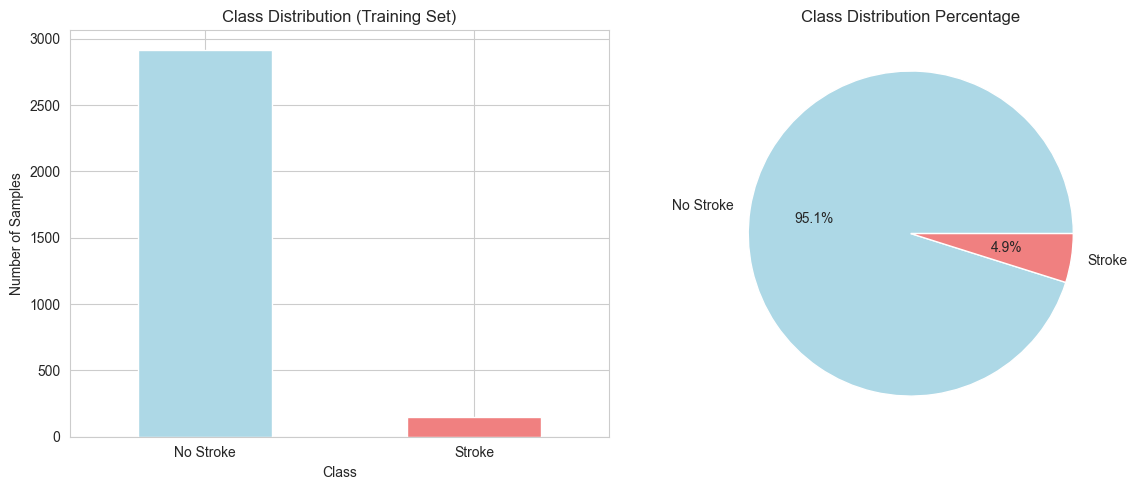

In [6]:
# Analyze class distribution
import os
os.makedirs('jupyter_notebooks/outputs/plots', exist_ok=True)

print("Class Distribution Analysis:")
print(f"Class 0 (No Stroke): {(y_train == 0).sum():,} samples")
print(f"Class 1 (Stroke): {(y_train == 1).sum():,} samples")
print(f"Imbalance ratio: {(y_train == 0).sum() / (y_train == 1).sum():.1f}:1")
print(f"Positive class percentage: {y_train.mean()*100:.1f}%")

# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
class_counts = pd.Series(y_train).value_counts().sort_index()
class_counts.plot(kind='bar', ax=ax1, color=['lightblue', 'lightcoral'])
ax1.set_title('Class Distribution (Training Set)')
ax1.set_xlabel('Class')
ax1.set_ylabel('Number of Samples')
ax1.set_xticklabels(['No Stroke', 'Stroke'], rotation=0)

# Pie chart
ax2.pie(class_counts.values, labels=['No Stroke', 'Stroke'], autopct='%1.1f%%', 
        colors=['lightblue', 'lightcoral'])
ax2.set_title('Class Distribution Percentage')

plt.tight_layout()
plt.savefig('jupyter_notebooks/outputs/plots/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## Handle Class Imbalance with SMOTE

After SMOTE balancing:
Class 0 (No Stroke): 2,917 samples
Class 1 (Stroke): 2,917 samples
New ratio: 1.0:1


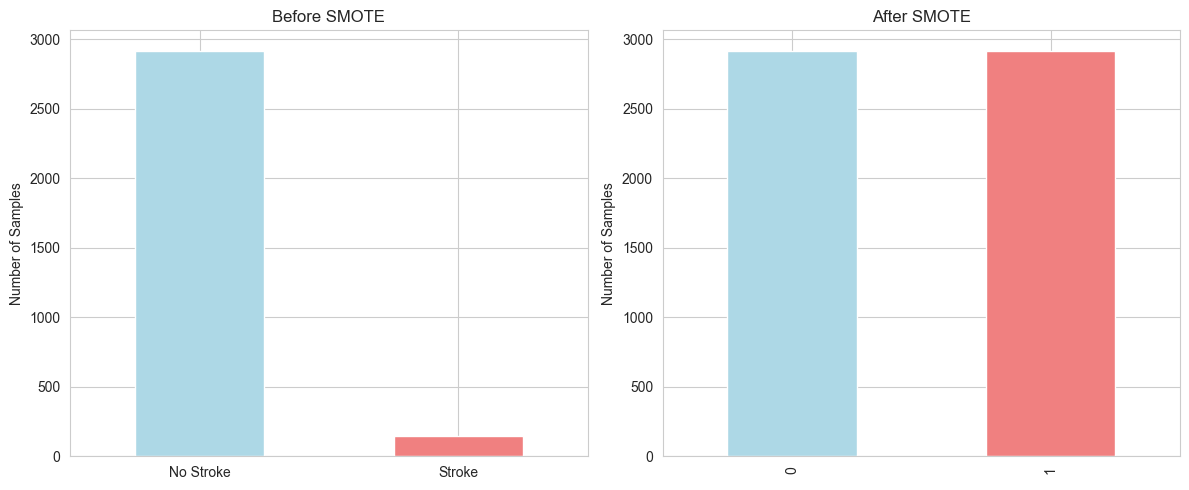

In [8]:
# Handle class imbalance with SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("After SMOTE balancing:")
print(f"Class 0 (No Stroke): {(y_train_balanced == 0).sum():,} samples")
print(f"Class 1 (Stroke): {(y_train_balanced == 1).sum():,} samples")
print(f"New ratio: {(y_train_balanced == 0).sum() / (y_train_balanced == 1).sum():.1f}:1")

# Visualize before and after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
pd.Series(y_train).value_counts().sort_index().plot(kind='bar', ax=axes[0], color=['lightblue', 'lightcoral'])
axes[0].set_title('Before SMOTE')
axes[0].set_ylabel('Number of Samples')
axes[0].set_xticklabels(['No Stroke', 'Stroke'], rotation=0)

# After SMOTE
pd.Series(y_train_balanced).value_counts().sort_index().plot(kind='bar', ax=axes[1], color=['lightblue', 'lightcoral'])
axes[1].set_title('After SMOTE')
axes[1].set_ylabel('Number of Samples')

plt.tight_layout()
plt.savefig('jupyter_notebooks/outputs/plots/smote_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

---
# Model Selection and Training

## Define Models and Hyperparameters

In [9]:
# Define models with initial parameters
models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2', 'elasticnet'],
            'solver': ['liblinear', 'saga']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10]
        }
    },
    'SVM': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['rbf', 'linear', 'poly'],
            'gamma': ['scale', 'auto', 0.001, 0.01]
        }
    },
    'K-Nearest Neighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
        }
    }
}

print(f"Defined {len(models)} models for comparison:")
for name in models.keys():
    print(f"- {name}")

Defined 5 models for comparison:
- Logistic Regression
- Random Forest
- Gradient Boosting
- SVM
- K-Nearest Neighbors


## Cross-Validation and Model Comparison

In [10]:
# Perform cross-validation for initial model comparison
cv_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Performing 5-fold cross-validation...\n")

for name, model_info in models.items():
    print(f"Evaluating {name}...")
    
    # Use default parameters for initial comparison
    model = model_info['model']
    
    # Cross-validation scores
    accuracy_scores = cross_val_score(model, X_train_balanced, y_train_balanced, 
                                     cv=cv, scoring='accuracy')
    precision_scores = cross_val_score(model, X_train_balanced, y_train_balanced, 
                                      cv=cv, scoring='precision')
    recall_scores = cross_val_score(model, X_train_balanced, y_train_balanced, 
                                   cv=cv, scoring='recall')
    f1_scores = cross_val_score(model, X_train_balanced, y_train_balanced, 
                               cv=cv, scoring='f1')
    roc_auc_scores = cross_val_score(model, X_train_balanced, y_train_balanced, 
                                    cv=cv, scoring='roc_auc')
    
    # Store results
    cv_results[name] = {
        'accuracy': accuracy_scores,
        'precision': precision_scores,
        'recall': recall_scores,
        'f1': f1_scores,
        'roc_auc': roc_auc_scores
    }
    
    print(f"  Accuracy: {accuracy_scores.mean():.3f} (+/- {accuracy_scores.std() * 2:.3f})")
    print(f"  Precision: {precision_scores.mean():.3f} (+/- {precision_scores.std() * 2:.3f})")
    print(f"  Recall: {recall_scores.mean():.3f} (+/- {recall_scores.std() * 2:.3f})")
    print(f"  F1-Score: {f1_scores.mean():.3f} (+/- {f1_scores.std() * 2:.3f})")
    print(f"  ROC-AUC: {roc_auc_scores.mean():.3f} (+/- {roc_auc_scores.std() * 2:.3f})")
    print()

print("Cross-validation completed!")

Performing 5-fold cross-validation...

Evaluating Logistic Regression...
  Accuracy: 0.794 (+/- 0.016)
  Precision: 0.754 (+/- 0.012)
  Recall: 0.873 (+/- 0.024)
  F1-Score: 0.809 (+/- 0.016)
  ROC-AUC: 0.851 (+/- 0.013)

Evaluating Random Forest...
  Accuracy: 0.794 (+/- 0.016)
  Precision: 0.754 (+/- 0.012)
  Recall: 0.873 (+/- 0.024)
  F1-Score: 0.809 (+/- 0.016)
  ROC-AUC: 0.851 (+/- 0.013)

Evaluating Random Forest...
  Accuracy: 0.975 (+/- 0.008)
  Precision: 0.978 (+/- 0.010)
  Recall: 0.972 (+/- 0.016)
  F1-Score: 0.975 (+/- 0.008)
  ROC-AUC: 0.997 (+/- 0.002)

Evaluating Gradient Boosting...
  Accuracy: 0.975 (+/- 0.008)
  Precision: 0.978 (+/- 0.010)
  Recall: 0.972 (+/- 0.016)
  F1-Score: 0.975 (+/- 0.008)
  ROC-AUC: 0.997 (+/- 0.002)

Evaluating Gradient Boosting...
  Accuracy: 0.961 (+/- 0.008)
  Precision: 0.969 (+/- 0.013)
  Recall: 0.952 (+/- 0.013)
  F1-Score: 0.960 (+/- 0.008)
  ROC-AUC: 0.991 (+/- 0.003)

Evaluating SVM...
  Accuracy: 0.961 (+/- 0.008)
  Precision: 0

## Visualize Cross-Validation Results

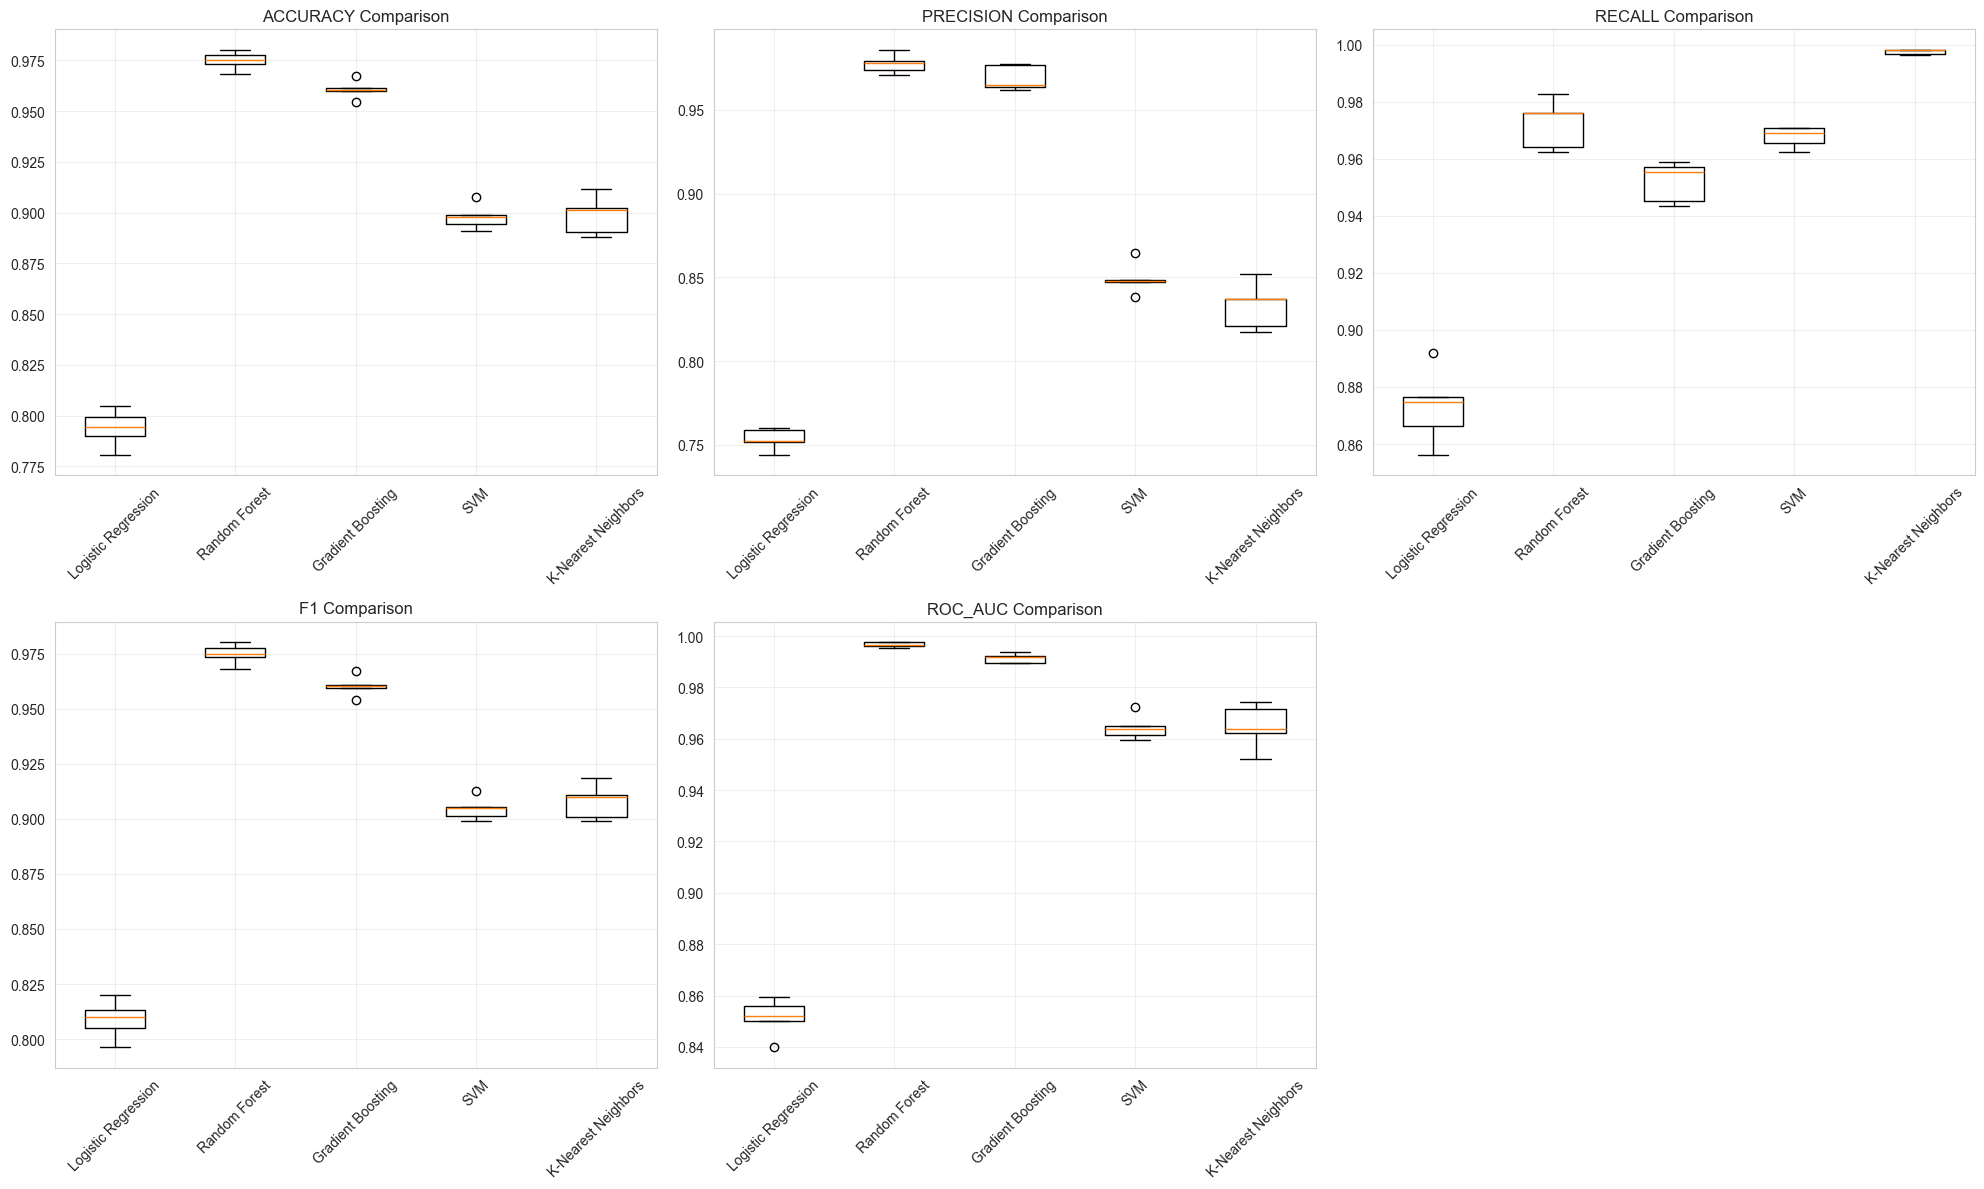

In [30]:
# Compare all models' cross-validation results
import os

# Create directory if it doesn't exist
os.makedirs('outputs/plots', exist_ok=True)

# Use the correct cv_results structure
models_results = cv_results

metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
metric_names = ['ACCURACY', 'PRECISION', 'RECALL', 'F1', 'ROC_AUC']

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, (metric, name) in enumerate(zip(metrics, metric_names)):
    data = [results[metric] for results in models_results.values()]
    axes[i].boxplot(data, labels=models_results.keys())
    axes[i].set_title(f'{name} Comparison')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)

# Remove the extra subplot
axes[-1].remove()

plt.tight_layout()
plt.savefig('outputs/plots/cv_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary Table of Cross-Validation Results

In [15]:
# Create a summary table of cross-validation results
import pandas as pd
import os

# First let's see the structure of cv_results
print("Structure of cv_results:")
for name, results in cv_results.items():
    print(f"{name}: {list(results.keys())[:5]}...")  # Show first 5 keys
    break

print("\nFull keys for first model:")
first_model = list(cv_results.keys())[0]
print(list(cv_results[first_model].keys()))

summary_data = []

for name, results in cv_results.items():
    summary_data.append({
        'Model': name,
        'Accuracy': f"{results['accuracy'].mean():.3f} ± {results['accuracy'].std():.3f}",
        'Precision': f"{results['precision'].mean():.3f} ± {results['precision'].std():.3f}",
        'Recall': f"{results['recall'].mean():.3f} ± {results['recall'].std():.3f}",
        'F1-Score': f"{results['f1'].mean():.3f} ± {results['f1'].std():.3f}",
        'ROC-AUC': f"{results['roc_auc'].mean():.3f} ± {results['roc_auc'].std():.3f}"
    })

summary_df = pd.DataFrame(summary_data)

print("\nCross-Validation Results Summary:")
print("=" * 80)
print(summary_df.to_string(index=False))

# Create directory if it doesn't exist and save results
os.makedirs('outputs/ml_pipeline', exist_ok=True)
summary_df.to_csv('outputs/ml_pipeline/cv_results_summary.csv', index=False)
print("\nResults saved to outputs/ml_pipeline/cv_results_summary.csv")

Structure of cv_results:
Logistic Regression: ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']...

Full keys for first model:
['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

Cross-Validation Results Summary:
              Model      Accuracy     Precision        Recall      F1-Score       ROC-AUC
Logistic Regression 0.794 ± 0.008 0.754 ± 0.006 0.873 ± 0.012 0.809 ± 0.008 0.851 ± 0.007
      Random Forest 0.975 ± 0.004 0.978 ± 0.005 0.972 ± 0.008 0.975 ± 0.004 0.997 ± 0.001
  Gradient Boosting 0.961 ± 0.004 0.969 ± 0.007 0.952 ± 0.006 0.960 ± 0.004 0.991 ± 0.002
                SVM 0.898 ± 0.005 0.849 ± 0.009 0.968 ± 0.003 0.905 ± 0.005 0.964 ± 0.004
K-Nearest Neighbors 0.899 ± 0.009 0.833 ± 0.013 0.998 ± 0.001 0.908 ± 0.007 0.965 ± 0.008

Results saved to outputs/ml_pipeline/cv_results_summary.csv


---
# Hyperparameter Tuning

## Select Top 3 Models for Hyperparameter Tuning

In [16]:
# Select top 3 models based on ROC-AUC score
roc_auc_means = {name: cv_results[name]['roc_auc'].mean() for name in model_names}
top_models = sorted(roc_auc_means.items(), key=lambda x: x[1], reverse=True)[:3]

print("Top 3 models based on ROC-AUC:")
for i, (model_name, score) in enumerate(top_models, 1):
    print(f"{i}. {model_name}: {score:.3f}")

top_model_names = [name for name, _ in top_models]
print(f"\nProceeding with hyperparameter tuning for: {top_model_names}")

Top 3 models based on ROC-AUC:
1. Random Forest: 0.997
2. Gradient Boosting: 0.991
3. K-Nearest Neighbors: 0.965

Proceeding with hyperparameter tuning for: ['Random Forest', 'Gradient Boosting', 'K-Nearest Neighbors']


## Hyperparameter Tuning with GridSearchCV

In [17]:
# Perform hyperparameter tuning for top models
tuned_models = {}
best_params = {}

for model_name in top_model_names:
    print(f"\nTuning hyperparameters for {model_name}...")
    
    model_info = models[model_name]
    base_model = model_info['model']
    param_grid = model_info['params']
    
    # Use RandomizedSearchCV for faster tuning
    search = RandomizedSearchCV(
        base_model, 
        param_grid, 
        n_iter=50,  # Reduced for faster execution
        cv=cv, 
        scoring='roc_auc',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    search.fit(X_train_balanced, y_train_balanced)
    
    # Store best model and parameters
    tuned_models[model_name] = search.best_estimator_
    best_params[model_name] = search.best_params_
    
    print(f"Best ROC-AUC for {model_name}: {search.best_score_:.3f}")
    print(f"Best parameters: {search.best_params_}")

print("\nHyperparameter tuning completed!")


Tuning hyperparameters for Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best ROC-AUC for Random Forest: 0.997
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}

Tuning hyperparameters for Gradient Boosting...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best ROC-AUC for Random Forest: 0.997
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}

Tuning hyperparameters for Gradient Boosting...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best ROC-AUC for Gradient Boosting: 0.995
Best parameters: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 7, 'learning_rate': 0.2}

Tuning hyperparameters for K-Nearest Neighbors...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best ROC-AUC for Gradient Boosting: 0.995
Best parameters: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 7, 'learn

---
# Final Model Training and Evaluation

## Train Final Models

In [18]:
# Train final tuned models
final_models = {}
final_predictions = {}
final_probabilities = {}

for model_name, model in tuned_models.items():
    print(f"Training final {model_name} model...")
    
    # Train on balanced data
    model.fit(X_train_balanced, y_train_balanced)
    
    # Make predictions on original test set
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Store results
    final_models[model_name] = model
    final_predictions[model_name] = y_pred
    final_probabilities[model_name] = y_proba
    
    print(f"  {model_name} training completed")

print("\nAll final models trained successfully!")

Training final Random Forest model...
  Random Forest training completed
Training final Gradient Boosting model...
  Random Forest training completed
Training final Gradient Boosting model...
  Gradient Boosting training completed
Training final K-Nearest Neighbors model...
  Gradient Boosting training completed
Training final K-Nearest Neighbors model...
  K-Nearest Neighbors training completed

All final models trained successfully!
  K-Nearest Neighbors training completed

All final models trained successfully!


## Model Performance Evaluation

In [19]:
# Calculate comprehensive metrics
performance_results = {}

print("Final Model Performance on Test Set:")
print("=" * 60)

for model_name in final_models.keys():
    y_pred = final_predictions[model_name]
    y_proba = final_probabilities[model_name]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    # Store results
    performance_results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }
    
    print(f"\n{model_name}:")
    print(f"  Accuracy:  {accuracy:.3f}")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall:    {recall:.3f}")
    print(f"  F1-Score:  {f1:.3f}")
    print(f"  ROC-AUC:   {roc_auc:.3f}")

Final Model Performance on Test Set:

Random Forest:
  Accuracy:  0.935
  Precision: 0.100
  Recall:    0.040
  F1-Score:  0.057
  ROC-AUC:   0.793

Gradient Boosting:
  Accuracy:  0.941
  Precision: 0.250
  Recall:    0.100
  F1-Score:  0.143
  ROC-AUC:   0.750

K-Nearest Neighbors:
  Accuracy:  0.847
  Precision: 0.137
  Recall:    0.400
  F1-Score:  0.204
  ROC-AUC:   0.726


## ROC Curves Comparison

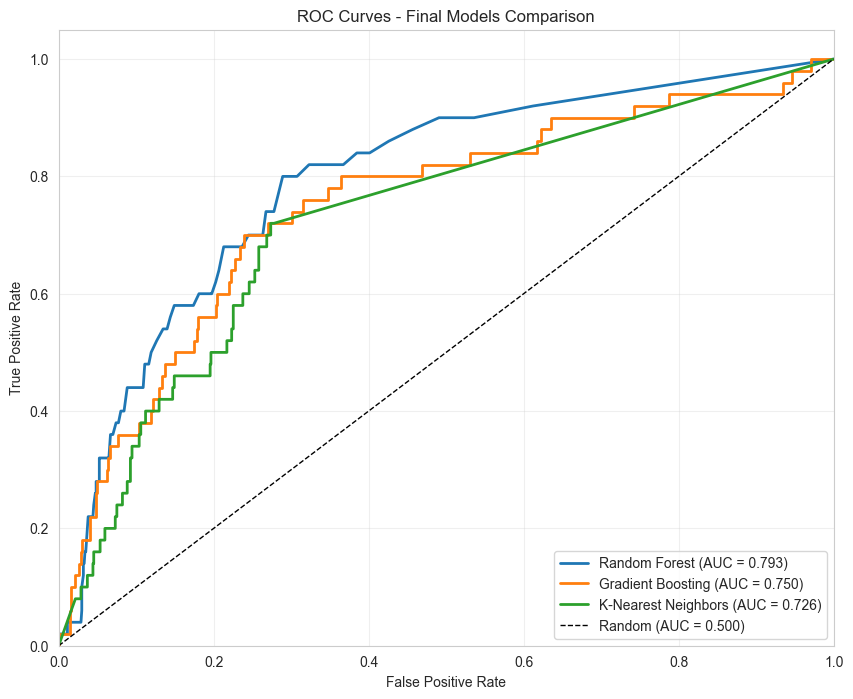

In [20]:
# Plot ROC curves for all final models
plt.figure(figsize=(10, 8))

for model_name in final_models.keys():
    y_proba = final_probabilities[model_name]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = performance_results[model_name]['roc_auc']
    
    plt.plot(fpr, tpr, linewidth=2, 
             label=f'{model_name} (AUC = {auc_score:.3f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC = 0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Final Models Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.savefig('outputs/plots/roc_curves_final.png', dpi=300, bbox_inches='tight')
plt.show()

## Precision-Recall Curves

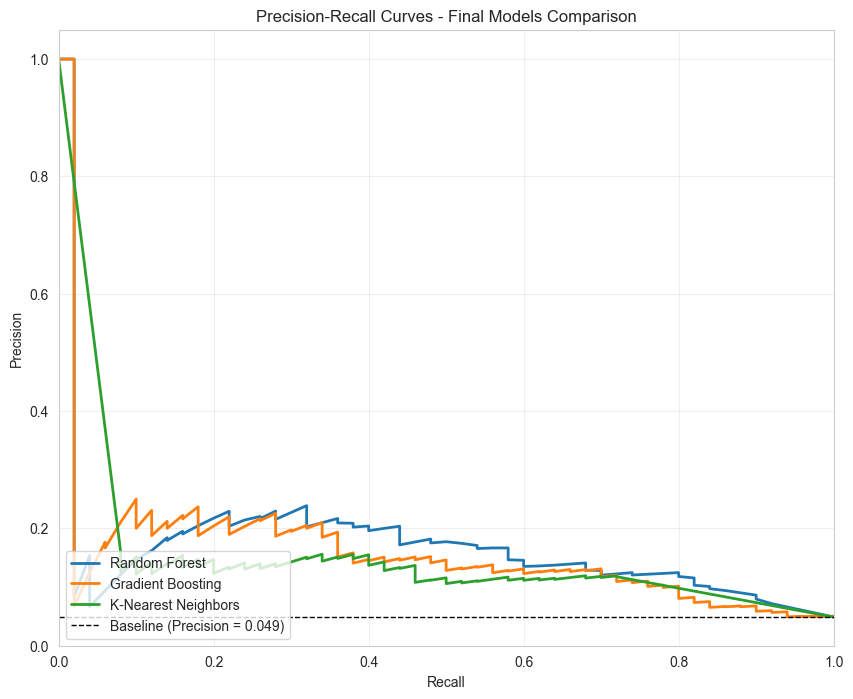

In [21]:
# Plot Precision-Recall curves
plt.figure(figsize=(10, 8))

baseline_precision = np.sum(y_test) / len(y_test)

for model_name in final_models.keys():
    y_proba = final_probabilities[model_name]
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
    
    plt.plot(recall_curve, precision_curve, linewidth=2, 
             label=f'{model_name}')

# Plot baseline
plt.axhline(y=baseline_precision, color='k', linestyle='--', linewidth=1,
           label=f'Baseline (Precision = {baseline_precision:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - Final Models Comparison')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)

plt.savefig('outputs/plots/precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()

---
# Model Selection and Feature Importance

## Select Best Model

In [22]:
# Select best model based on ROC-AUC (primary) and F1-score (secondary)
best_model_name = max(performance_results.keys(), 
                     key=lambda x: (performance_results[x]['roc_auc'], 
                                   performance_results[x]['f1']))

best_model = final_models[best_model_name]
best_performance = performance_results[best_model_name]

print(f"Best Model Selected: {best_model_name}")
print("=" * 40)
print(f"ROC-AUC:   {best_performance['roc_auc']:.3f}")
print(f"F1-Score:  {best_performance['f1']:.3f}")
print(f"Precision: {best_performance['precision']:.3f}")
print(f"Recall:    {best_performance['recall']:.3f}")
print(f"Accuracy:  {best_performance['accuracy']:.3f}")

# Save best model
joblib.dump(best_model, f'outputs/ml_pipeline/best_model_{best_model_name.lower().replace(" ", "_")}.pkl')
print(f"\nBest model saved to outputs/ml_pipeline/best_model_{best_model_name.lower().replace(' ', '_')}.pkl")

Best Model Selected: Random Forest
ROC-AUC:   0.793
F1-Score:  0.057
Precision: 0.100
Recall:    0.040
Accuracy:  0.935

Best model saved to outputs/ml_pipeline/best_model_random_forest.pkl

Best model saved to outputs/ml_pipeline/best_model_random_forest.pkl


## Feature Importance Analysis

Top 15 Most Important Features:
 1. feature_0                 0.2202
 2. feature_21                0.1038
 3. feature_19                0.0739
 4. feature_1                 0.0636
 5. feature_2                 0.0586
 6. feature_20                0.0537
 7. feature_15                0.0486
 8. feature_12                0.0389
 9. feature_10                0.0384
10. feature_5                 0.0360
11. feature_3                 0.0346
12. feature_13                0.0300
13. feature_6                 0.0298
14. feature_23                0.0251
15. feature_16                0.0248


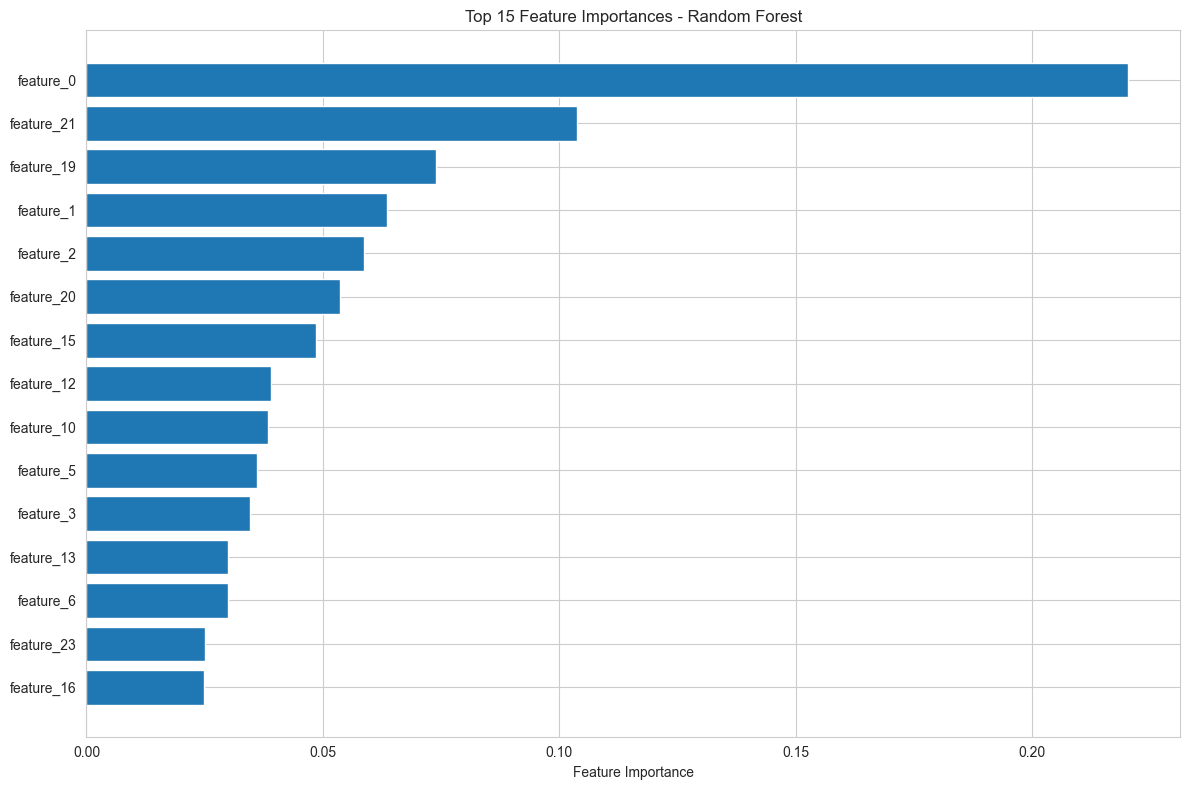


Feature importance saved to outputs/ml_pipeline/feature_importance.csv

Total number of features: 27
Top 5 features account for 52.0% of total importance


In [25]:
# Feature importance analysis for tree-based models
if hasattr(best_model, 'feature_importances_'):
    # Create generic feature names based on the number of features
    n_features = len(best_model.feature_importances_)
    feature_names = [f'feature_{i}' for i in range(n_features)]
    
    importances = best_model.feature_importances_
    
    # Create feature importance dataframe
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("Top 15 Most Important Features:")
    print("=" * 50)
    for i, (feature, importance) in enumerate(feature_importance_df.head(15).values, 1):
        print(f"{i:2d}. {feature:<25} {importance:.4f}")
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importances - Random Forest')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    
    # Save plot
    os.makedirs('outputs/plots', exist_ok=True)
    plt.savefig('outputs/plots/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save feature importance data
    feature_importance_df.to_csv('outputs/ml_pipeline/feature_importance.csv', index=False)
    print(f"\nFeature importance saved to outputs/ml_pipeline/feature_importance.csv")
    
    print(f"\nTotal number of features: {n_features}")
    print(f"Top 5 features account for {feature_importance_df.head(5)['importance'].sum():.1%} of total importance")
else:
    print("Selected model doesn't have feature_importances_ attribute")

---
# Save All Models and Results

In [26]:
# Save all final models
for model_name, model in final_models.items():
    filename = f"outputs/ml_pipeline/{model_name.lower().replace(' ', '_')}_model.pkl"
    joblib.dump(model, filename)
    print(f"Saved {model_name} to {filename}")

# Save performance results
performance_df = pd.DataFrame(performance_results).T
performance_df.to_csv('outputs/ml_pipeline/final_model_performance.csv')
print("\nSaved performance results to outputs/ml_pipeline/final_model_performance.csv")

# Save best model parameters
import json
with open('outputs/ml_pipeline/best_model_params.json', 'w') as f:
    # Convert numpy types to native Python types for JSON serialization
    serializable_params = {}
    for model_name, params in best_params.items():
        serializable_params[model_name] = {}
        for key, value in params.items():
            if isinstance(value, np.integer):
                serializable_params[model_name][key] = int(value)
            elif isinstance(value, np.floating):
                serializable_params[model_name][key] = float(value)
            else:
                serializable_params[model_name][key] = value
    
    json.dump(serializable_params, f, indent=2)

print("Saved best model parameters to outputs/ml_pipeline/best_model_params.json")

print("\n" + "="*60)
print("MODEL DEVELOPMENT COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"Best Model: {best_model_name}")
print(f"Best ROC-AUC: {best_performance['roc_auc']:.3f}")
print(f"All models and results saved to outputs/ml_pipeline/")

Saved Random Forest to outputs/ml_pipeline/random_forest_model.pkl
Saved Gradient Boosting to outputs/ml_pipeline/gradient_boosting_model.pkl
Saved K-Nearest Neighbors to outputs/ml_pipeline/k-nearest_neighbors_model.pkl

Saved performance results to outputs/ml_pipeline/final_model_performance.csv
Saved best model parameters to outputs/ml_pipeline/best_model_params.json

MODEL DEVELOPMENT COMPLETED SUCCESSFULLY!
Best Model: Random Forest
Best ROC-AUC: 0.793
All models and results saved to outputs/ml_pipeline/
